In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
%matplotlib inline

from importlib import reload

from utils import saveVideo, show, drawShape

import laneFindingPipeline

In [2]:
undistort = laneFindingPipeline.Undistorter()

from glob import glob
undistort.fit(glob('camera_cal/*.jpg'))

A Jupyter Widget

In [3]:
# Load video
videoPrefix = 'project'
fpath = '%s_video.mp4' % videoPrefix
import skvideo.io
reader = skvideo.io.FFmpegReader(fpath)
frames = []
for (i, f) in enumerate(tqdm.tqdm_notebook(
    reader.nextFrame(), 
    total=reader.inputframenum,
)):
    frames.append(f)

A Jupyter Widget

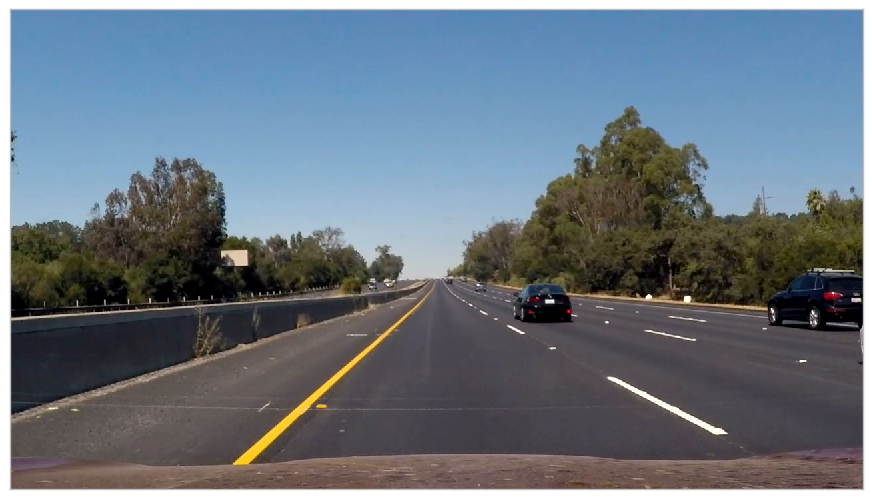

In [4]:
show(frames[-1]);

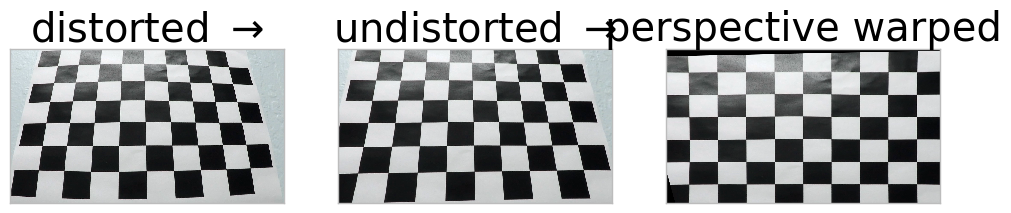

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
dist = cv2.imread('camera_cal/calibration3.jpg')
undist = undistort(dist)
show(dist, axes[0], r'distorted $\rightarrow$')
show(undist, axes[1], r'undistorted $\rightarrow$')
show(laneFindingPipeline.transformChessboard(undist), axes[2], 'perspective warped')
fig.savefig('doc/undistorted.png')

Set parameters for perspective transform.

In [6]:
perspective = laneFindingPipeline.PerspectiveTransformer()

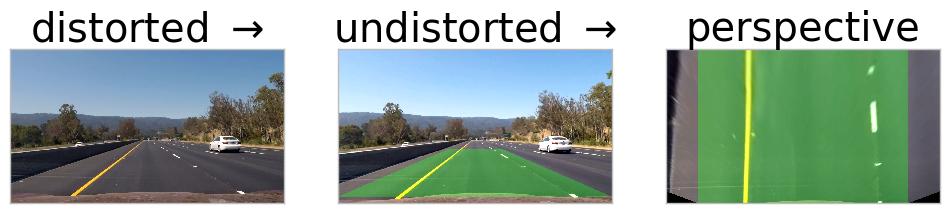

In [7]:
dist = frames[400]
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
undist = undistort(dist)
show(dist, axes[0], r'distorted $\rightarrow$')
show(drawShape(undist, perspective.src), axes[1], r'undistorted $\rightarrow$')

show(drawShape(perspective(undist), perspective.dst), axes[2], 'perspective')
fig.savefig('doc/undistorted-road.png')

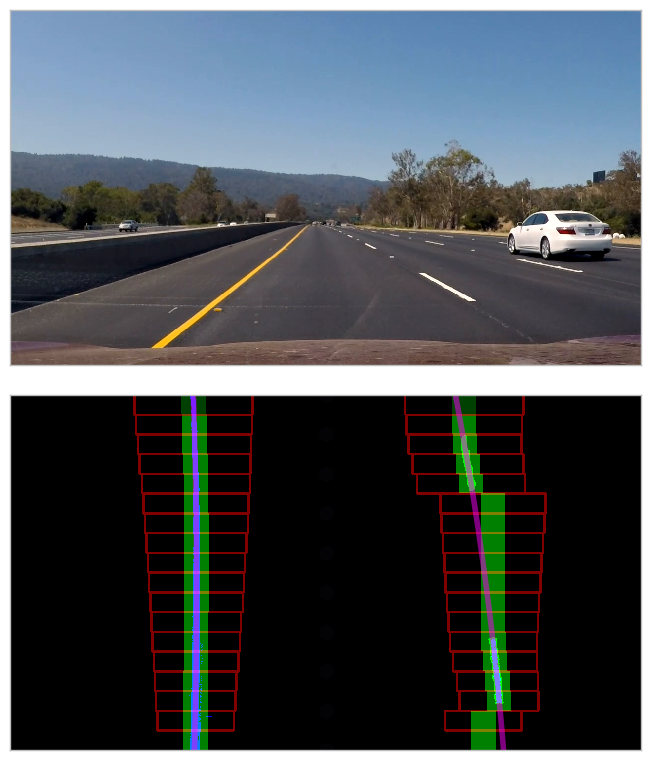

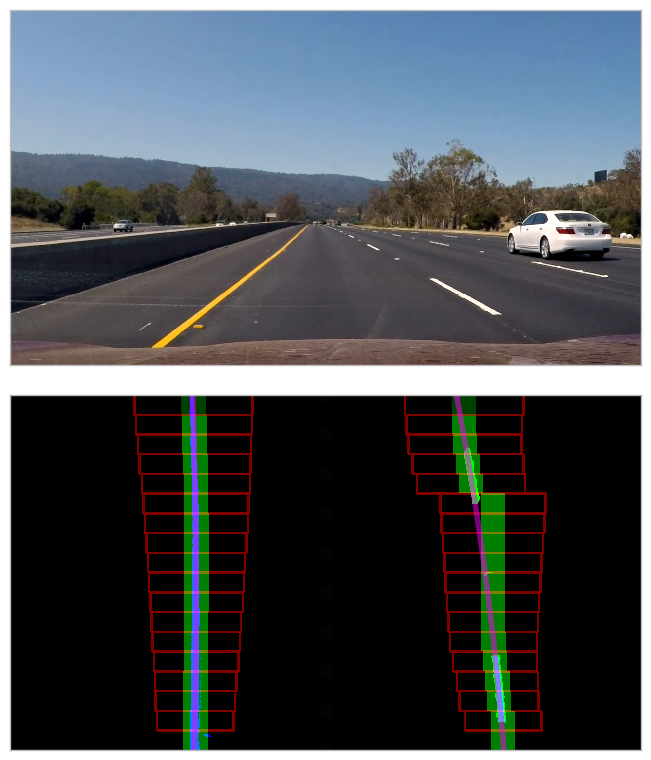

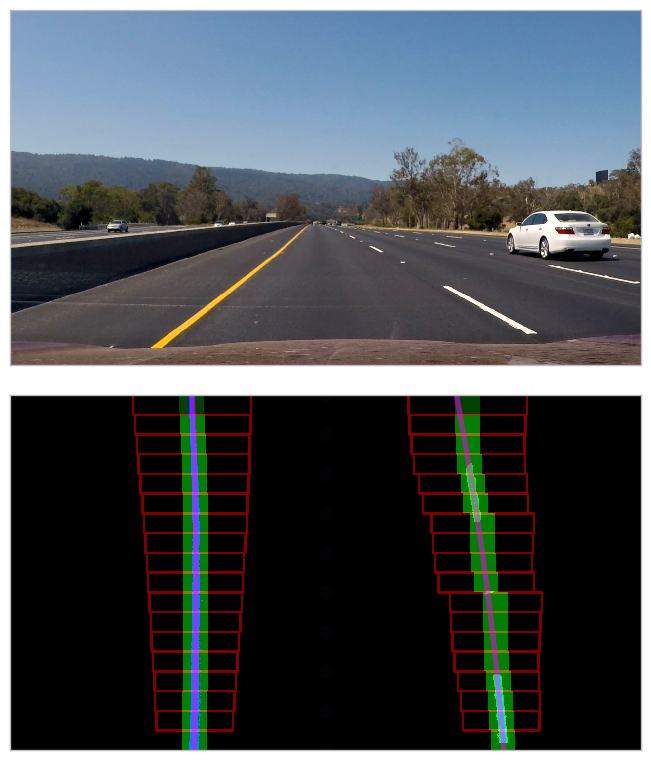

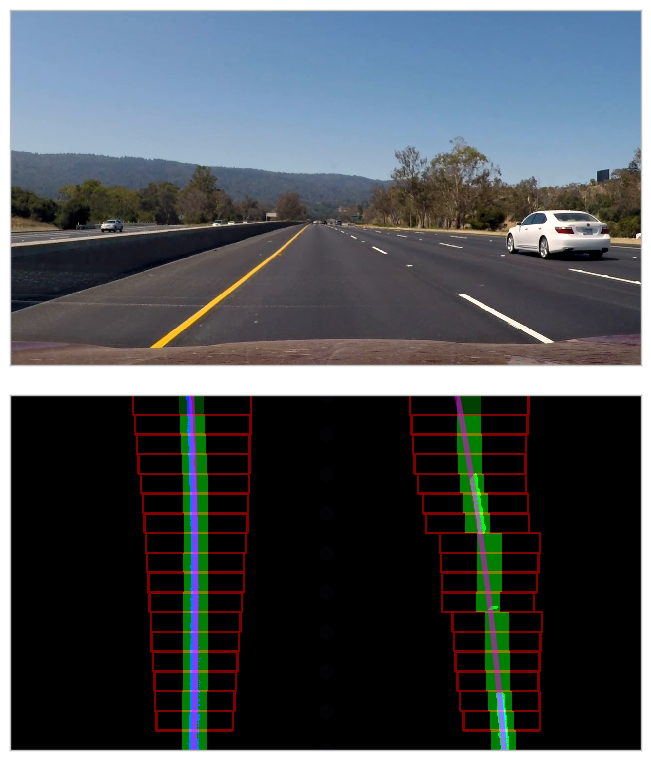

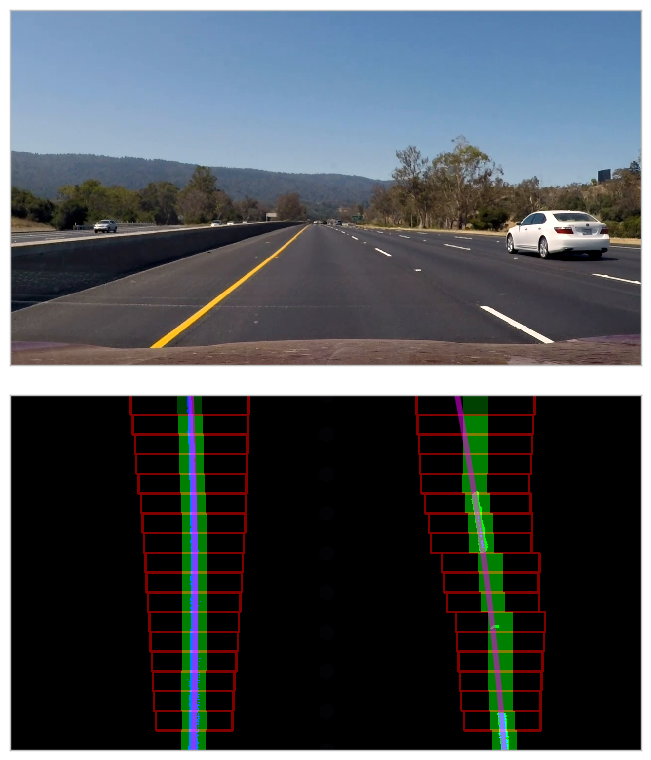

In [8]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort=undistort)
for k in range(298, 303):
    laneFinder.show(frames[k]);

In [9]:
import utils

Measure FPS without plotting.

I used to get 15-17 FPS here, but I think adding all the dilations to the threshold filter was probably what reduced it to 12.

In [10]:
%%time
laneFinder = laneFindingPipeline.LaneFinder(undistort)
for frame in tqdm.tqdm_notebook(frames[:100], unit='frame'):
    laneFinder(frame)

A Jupyter Widget


CPU times: user 9.73 s, sys: 56 ms, total: 9.79 s
Wall time: 8.04 s


# Show the result unperspective'd.

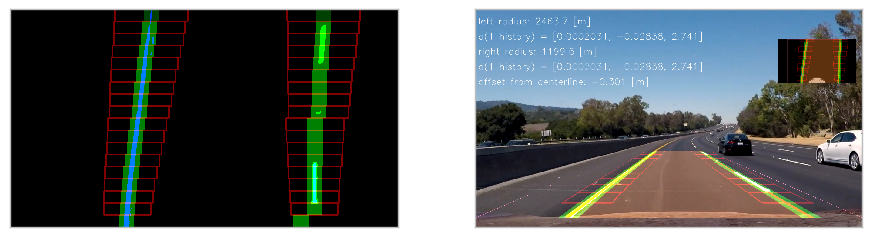

In [11]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort=undistort)
frame = frames[1100]

# warped = laneFinder.perspective(laneFinder.undistort(frame))
# hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
# show(hls[:, :, 2])

fig, (ax, bx) = plt.subplots(ncols=2)

repro = laneFinder.preprocess(frame, color=True)
painted = laneFinder.markingFinder.paint(laneFinder.preprocess(frame, color=False))
composite = cv2.addWeighted(repro, 1, painted, 0.5, 0)
show(composite, ax=ax);

show(laneFinder.draw(frame, showTrapezoid=True, showLane=True), ax=bx);

In [12]:
reload(laneFindingPipeline)

vids = []

# Load video
for videoPrefix in ('project', 'challenge', 'harder_challenge'):
    fpath = '%s_video.mp4' % videoPrefix
    import skvideo.io
    reader = skvideo.io.FFmpegReader(fpath)
    frames = []
    for (i, f) in enumerate(tqdm.tqdm_notebook(
        reader.nextFrame(), 
        total=reader.inputframenum,
        desc='load %s' % videoPrefix
    )):
        frames.append(f)

    inputFrames = frames
    # inputFrames = frames[500:690]
    # inputFrames = frames[900:]

    laneFinder = laneFindingPipeline.LaneFinder(undistort)
    vid = saveVideo((
        laneFinder.draw(frame)
        for frame in inputFrames
    ), 'drawn-weighted-%s.mp4' % videoPrefix, total=len(inputFrames), desc='save %s' % videoPrefix)
    vids.append(vid)

A Jupyter Widget

A Jupyter Widget

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!



A Jupyter Widget

A Jupyter Widget

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)



A Jupyter Widget

A Jupyter Widget

Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed ins

/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)


/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!


/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)


/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!


/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)
/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py:713: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y , order)


Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

/home/tsbertalan/.virtualenvs/carnd-term1/lib/python3.5/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [128]:
np.polyfit?